# Imports

In [1]:
import geopandas as gpd #local shape processing
import rioxarray as rxr #local raster processing
import leafmap #local interactive visualisation
import matplotlib.pyplot as plt #python plotting package
import numpy as np #python array package

# Shape processing

## Read shapes

In [2]:
catchment_gdf = gpd.read_file("data/catchment.geojson")
river_gdf = gpd.read_file("data/river.shp")

## Plot shape

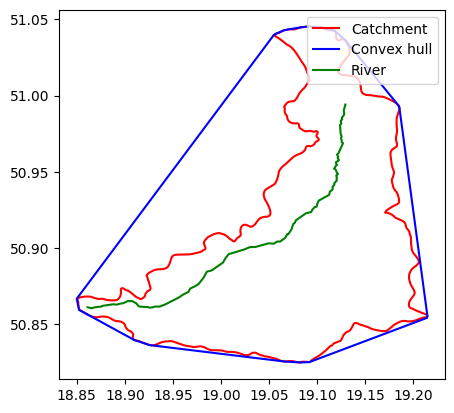

In [3]:
fig, ax = plt.subplots()
catchment_gdf.boundary.plot(ax=ax, color="red", label="Catchment")
catchment_gdf.convex_hull.boundary.plot(ax=ax, color="blue", label="Convex hull")
river_gdf.plot(ax=ax, color="green", label="River")
plt.legend()

# Raster processing
## Load HDF dataset

In [4]:
modis_hdf = rxr.open_rasterio("data/MOD11A1.A2022272.h19v03.061.2022273091950.hdf", cache=False)
modis_hdf

<xarray.Dataset>
Dimensions:          (band: 1, x: 1200, y: 1200)
Coordinates:
  * band             (band) int64 1
  * x                (x) float64 1.112e+06 1.113e+06 ... 2.223e+06 2.223e+06
  * y                (y) float64 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref      int64 0
Data variables:
    LST_Day_1km      (band, y, x) uint16 ...
    Emis_32          (band, y, x) uint8 ...
    Clear_day_cov    (band, y, x) uint16 ...
    Clear_night_cov  (band, y, x) uint16 ...
    QC_Day           (band, y, x) uint8 ...
    Day_view_time    (band, y, x) uint8 ...
    Day_view_angl    (band, y, x) uint8 ...
    LST_Night_1km    (band, y, x) uint16 ...
    QC_Night         (band, y, x) uint8 ...
    Night_view_time  (band, y, x) uint8 ...
    Night_view_angl  (band, y, x) uint8 ...
    Emis_31          (band, y, x) uint8 ...
Attributes: (12/117)
    ALGORITHMPACKAGEACCEPTANCEDATE:     102004
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR11A
    ALGORITHMPACKAGEVERSION:            6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            50.0041666666667
    SPSOPARAMETERS:                     2484 and 3323
    TileID:                             51019003
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.5534662098949

## Get raster from HDF

In [5]:
#select LST product from hdf
lst = modis_hdf["LST_Day_1km"]

## Scaling pixel values

In [6]:
#apply scaling (value from MODIS documentation)
lst[0] = lst[0]*0.02


## Nodata

### Nodata issue

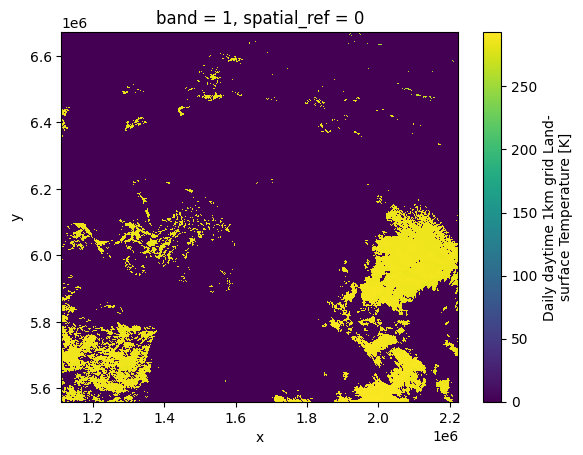

In [7]:
#plot LST
lst.plot(cmap="viridis")

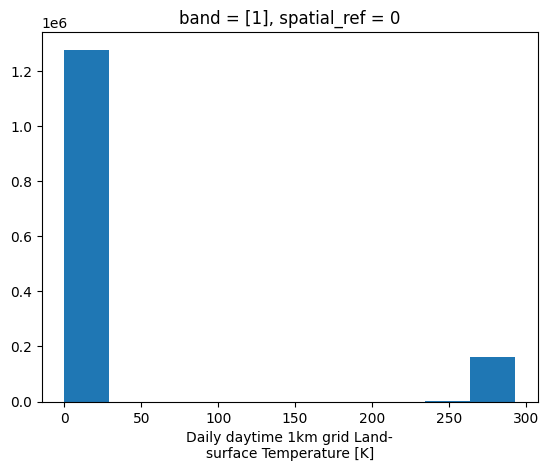

In [8]:
lst.plot.hist()
plt.show()

In [9]:
print(f"nodata: {lst.rio.nodata}")
print(f"encoded_nodata: {lst.rio.encoded_nodata}")

nodata: 0
encoded_nodata: None


### Masking nodata

In [10]:
#mask nodata
lst = lst.where(lst!=lst.rio.nodata)
#write nodata metadata
lst = lst.rio.write_nodata(-9999, encoded=True)

nodata: nan
encoded_nodata: -9999.0


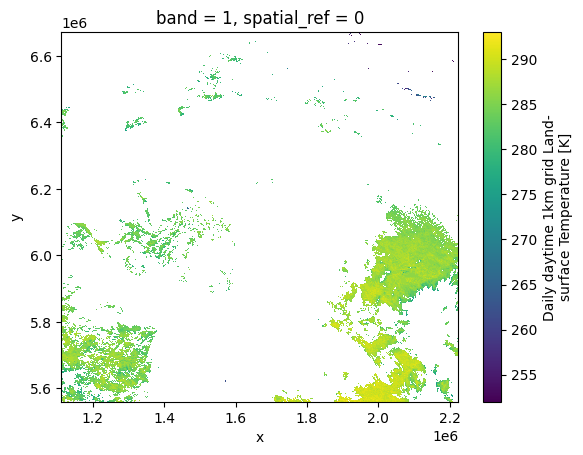

In [11]:
print(f"nodata: {lst.rio.nodata}")
print(f"encoded_nodata: {lst.rio.encoded_nodata}")
lst.plot(cmap="viridis")

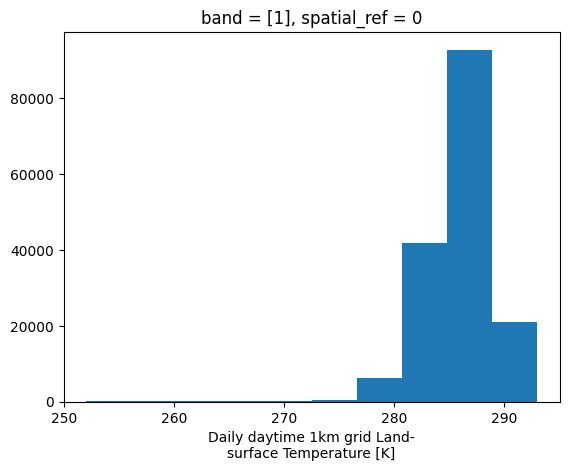

In [12]:
lst.plot.hist()
plt.show()

## Save raster

In [13]:
#save LST to tif file
lst.rio.to_raster("data/lst.tif")

# Raster and shape processing

## Crop raster using shape

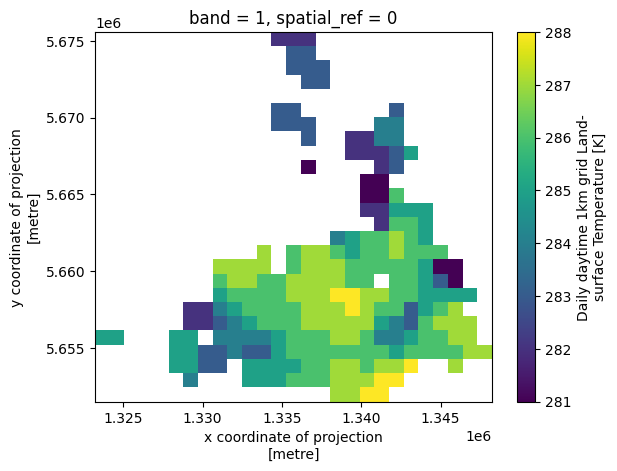

In [14]:
lst = lst.rio.clip(catchment_gdf.geometry.values,catchment_gdf.crs)
lst.rio.to_raster("data/lst_cropped.tif")
lst.plot(cmap="viridis")

## Plot raster and shape on one canvas

### Problem with plotting different CRS

<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

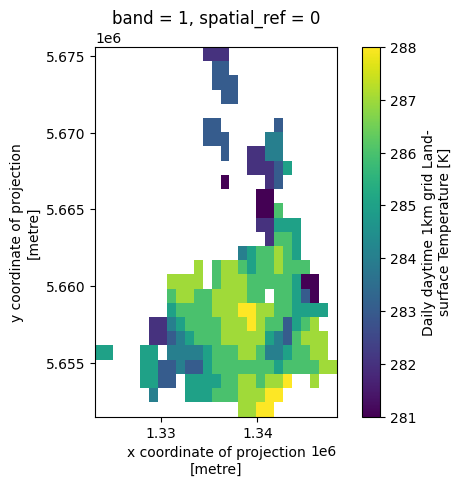

In [15]:
#plot results
fig, ax = plt.subplots()
lst.plot(ax=ax, cmap="viridis")
catchment_gdf.boundary.plot(ax=ax, color="red")

### Shape reprojection

In [16]:
catchment_gdf_sin = catchment_gdf.to_crs(lst.rio.crs)

<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

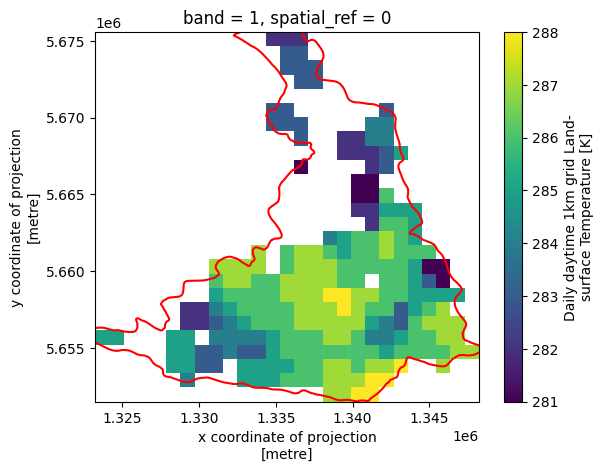

In [17]:
#plot results
fig, ax = plt.subplots()
lst.plot(ax=ax)
catchment_gdf_sin.boundary.plot(ax=ax, color="red")

## Raster reprojection

CRS before reprojection: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]



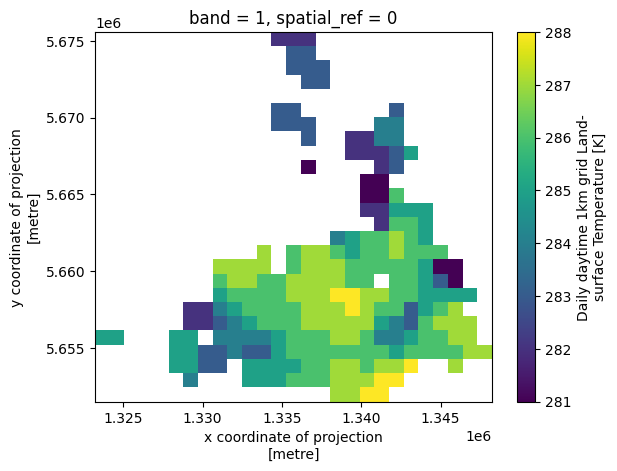

In [18]:
print(f"CRS before reprojection: {lst.rio.crs}\n")
lst.plot(cmap="viridis")

CRS after reprojection: EPSG:4326


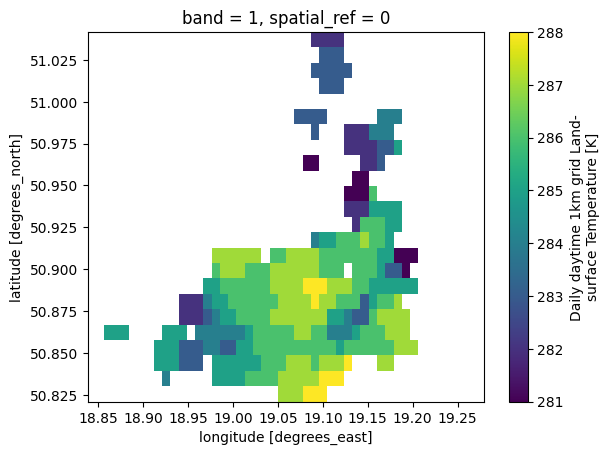

In [19]:
lst = lst.rio.reproject("EPSG:4326")
print(f"CRS after reprojection: {lst.rio.crs}")
lst.plot(cmap="viridis")

## Probe raster values at line

### Reproject line to meters based CRS
What UTM zone am I in? UTM Zone: 34 (EPSG:32634)\
https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-%23


In [20]:
print(f"river length before reprojection: {river_gdf.length[0]}")
river_gdf_utm = river_gdf.to_crs("EPSG:32634")
print(f"river length after reprojection: {river_gdf_utm.length[0]}")

river length before reprojection: 0.3561388641204535
river length after reprojection: 29061.79754870151


### Generate points along line

In [21]:
from shapely.geometry import MultiPoint
distance_delta = 3000
distances = np.arange(0, river_gdf_utm.length[0], distance_delta)
points = [river_gdf_utm.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:32634")
river_pts_gdf = river_pts_gdf.to_crs("EPSG:4326")

### Sample raster value at points

In [22]:
lst_vals = []
for index, row in river_pts_gdf.iterrows():
    lst_vals.append(lst.sel(x=row.geometry.x,y=row.geometry.y, method="nearest").item())
river_pts_gdf["lst"] = lst_vals
river_pts_gdf

,geometry,lst
0,POINT (18.86011 50.86128),285.0
1,POINT (18.90152 50.86487),NaN
2,POINT (18.94132 50.86298),285.0
3,POINT (18.97705 50.87686),285.0
4,POINT (19.00658 50.89498),287.0
5,POINT (19.04676 50.90271),287.0
6,POINT (19.07718 50.91730),NaN
7,POINT (19.10822 50.93348),NaN
8,POINT (19.12037 50.95442),NaN
9,POINT (19.12407 50.97775),282.0


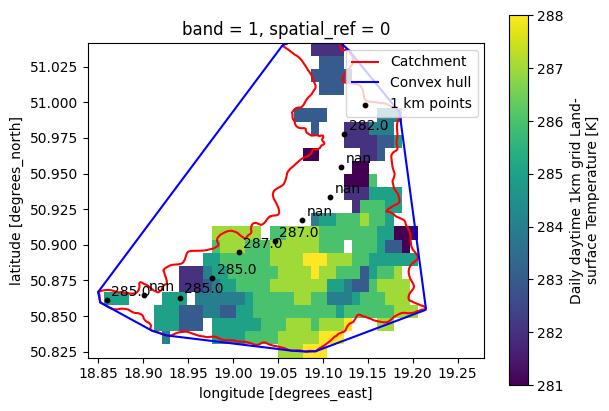

In [23]:
fig, ax = plt.subplots()
lst.plot(ax=ax)
catchment_gdf.boundary.plot(ax=ax, color="red", label="Catchment")
catchment_gdf.convex_hull.boundary.plot(ax=ax, color="blue", label="Convex hull")
river_pts_gdf.plot(ax=ax, color="black", label="1 km points", markersize=10)
for x, y, label in zip(river_pts_gdf.geometry.x, river_pts_gdf.geometry.y, river_pts_gdf.lst):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.legend()

# Interactive map visualization

In [24]:
Map = leafmap.Map()
#visualise raster by path
Map.add_raster("data/lst_cropped.tif", layer_name="LST", cmap="viridis")
#visualise shape by path
Map.add_geojson("data/catchment.geojson", layer_name="Catchment", fill_colors=['red'])
#visualise geodataframe shape object
Map.add_gdf(catchment_gdf.convex_hull, layer_name="Catchment - convex hull", fill_colors=['blue'])
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…